# Artificial and Computational Intelligence Assignment 1

## Problem solving by Uninformed & Informed Search

List all the team members BITS ID ,Name along with % of contribution in this assignment: sample Provided below:
1. 2025AE05517  |  NIMISHAMBA S                     | 100%
2. 2025AE05518  |  JITENDRA KR TIWARI               | 100%
3. 2025AE05519  |  DADDEKAR ROHIT TUKARAM VAISHALI  | 100%
4. 2025AE05520  |  RASMITA JENA                     | 100%
5. 2025AE05521  |  C. AJAY KUMAR                    | 100%

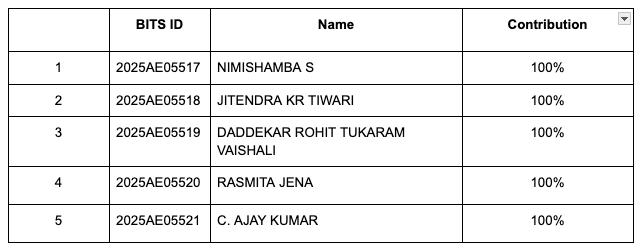

Things to follow
1.	Use appropriate data structures to represent the graph and the path using python libraries
2.	Provide proper documentation
3.	Find the path and print it

Coding begins here

### 1.	Define the environment in the following block

List the PEAS decription of the problem here in this markdown block

Design the agent as PSA Agent(Problem Solving Agent)
Clear Initial data structures to define the graph and variable declarations is expected
IMPORTATANT: Write distinct code block as below

In [23]:
#Code Block : Set Initial State (Must handle dynamic inputs)


from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, FrozenSet
from collections import defaultdict
import heapq, time, tracemalloc

# Node & edge aliases
Node = str
Weight = float
Edge = Tuple[Node, Node, Weight]      # (u, v, w)
Action = Tuple[Node, Node]            # move u -> v (undirected unified id)

# Short codes ↔ full names (both dynamic inputs accepted)
code_to_name = {
    "pu": "Purasawalkam",
    "pe": "Perumbakkam",
    "v" : "Velachery",
    "g" : "Guindy",
    "t" : "Tambaram",
    "n" : "Nungambakkam",
}
name_to_code = {v:k for k,v in code_to_name.items()}

# Accept short codes or full names; always return a canonical full name
def normalize_vertex(x: str) -> Node:
    # Accepts 'n' or 'Nungambakkam' and returns full name
    x = x.strip()
    if x.lower() in code_to_name:       # "n" -> "Nungambakkam"
        return code_to_name[x.lower()]
    for full in code_to_name.values():  # "nungambakkam" -> "Nungambakkam"
        if full.lower() == x.lower():
            return full
    raise ValueError(f"Unknown vertex: {x}")

@dataclass(frozen=True)
class EulerState:
    node: Node                  # current node
    used_edges: FrozenSet[int]   # undirected edges that have been used already

def make_initial_state(start_state: str) -> EulerState:
    # Create initial Euler search state from dynamic input
    start_node = normalize_vertex(start_state)
    return EulerState(node=start_node, used_edges=frozenset())

In [24]:
#Code Block : Set the matrix for transition & cost (as relevant for the given problem)

class Graph:
    # Undirected weighted graph for the Chennai flood-relief map
    def __init__(self):
        self.adj: Dict[Node, List[Tuple[Node, Weight]]] = defaultdict(list)
        self.edge_id: Dict[Tuple[Node, Node], int] = {}                         # same id for (u,v) and (v,u)
        self.edges: List[Edge] = []
        self.vertices = set()

    def add_edge(self, u: Node, v: Node, w: Weight):
        # Skip adding a duplicate undirected edge example for (u,v) and (v,u) only single edge_id is used
        if (v,u) in self.edge_id:
            return
        eid = len(self.edges)
        self.edges.append((u, v, w))
        self.edge_id[(u, v)] = eid
        self.edge_id[(v, u)] = eid
        self.adj[u].append((v, w))
        self.adj[v].append((u, w))
        self.vertices.add(u); self.vertices.add(v)

    def degree(self, u: Node) -> int:
        return len(self.adj.get(u, []))

    def num_edges(self) -> int:
        return len(self.edges)

    def total_edge_cost(self) -> float:
        # sum of all distinct undirected edges
        return float(sum(w for _,_,w in self.edges))

    def display(self):
        print(f"Vertices ({len(self.vertices)}): {sorted(self.vertices)}")
        print(f"Edges ({len(self.edges)}):")
        for (u,v,w) in sorted(self.edges):
            print(f"  {u} ↔ {v}: {w}")

def build_chennai_graph() -> Graph:
    g = Graph()
    g.add_edge("Nungambakkam",  "Guindy",       12)
    g.add_edge("Guindy",        "Velachery",    14)
    g.add_edge("Nungambakkam",  "Tambaram",     15)
    g.add_edge("Guindy",        "Tambaram",     10)
    g.add_edge("Guindy",        "Perumbakkam",   7)
    g.add_edge("Velachery",     "Perumbakkam",   6)
    g.add_edge("Perumbakkam",   "Tambaram",     11)
    g.add_edge("Perumbakkam",   "Purasawalkam",  8)
    g.add_edge("Tambaram",      "Purasawalkam",  9)
    return g

# Initialize global graph once for reuse by any algorithm
chennai_graph = build_chennai_graph()

In [25]:
#Code Block : Write function to design the Transition Model/Successor function. Ideally this would be called while search algorithms are implemented


def euler_successors(state: EulerState, graph: Graph) -> List[Tuple[EulerState, Action, float]]:
    # Successors for Euler search: from current node, take any unused incident edge.
    # Returns list of (next_state, action=(u,v), step_cost).
    u = state.node
    succ = []
    for (v, w) in graph.adj.get(u, []):                 # Consider all neighbors (v, w) of current node u
        eid = graph.edge_id[(u, v)]
        if eid in state.used_edges:                     # skip already used edges
            continue
        new_used = set(state.used_edges); new_used.add(eid)
        succ.append( (EulerState(v, frozenset(new_used)), (u, v), float(w)) )
    return succ

def euler_transition(state: EulerState, action: Action, graph: Graph) -> Tuple[EulerState, float]:
    # Deterministic transition model: apply (u->v) if unused; return (next_state, cost).
    u, v = action
    if u != state.node:                     # ensure action is applicable/allowed
        raise ValueError(f"Action {action} invalid at node {state.node}")
    eid = graph.edge_id[(u, v)]
    if eid in state.used_edges:             # edge must be unused
        raise ValueError(f"Edge {action} already used")
    cost = None                             # find (u,v) cost in adjacency
    for (neighbor, w) in graph.adj[u]:
        if neighbor == v:
            cost = float(w)
            break
    if cost is None:
        raise KeyError(f"No edge {u}↔{v} in graph")
    new_used = set(state.used_edges); new_used.add(eid)
    return EulerState(v, frozenset(new_used)), cost

# Compute total travel cost along path.
def path_cost(path: List[Node], g: Graph) -> float:
    if not path or len(path) < 2:
        return 0.0
    total = 0.0
    for u, v in zip(path[:-1], path[1:]):
        found = False
        for (neighbor, w) in g.adj[u]:
            if neighbor == v:
                total += float(w)
                found = True
                break
        if not found:
            raise KeyError(f"Edge {u}↔{v} not in graph")
    return total

In [26]:
#Code block : Write function to handle goal test (Must handle dynamic inputs). Ideally this would be called while search algorithms are implemented


def is_goal_euler(state: EulerState, g: Graph) -> bool:
    # Euler goal: all undirected edges are used exactly once.
    return len(state.used_edges) == g.num_edges()

def has_euler_trail(g: Graph) -> bool:
    # Euler trail in undirected graph only exists if has 0 or 2 vertices of odd degree.
    odd = [u for u in g.vertices if g.degree(u) % 2 == 1]
    return len(odd) in (0, 2)

# Returns True if the current node matches the specified goal(destination) node.
def is_goal_node(current: Node, goal_state: Optional[str]) -> bool:
    if not goal_state:
        return False
    return normalize_vertex(goal_state) == current

### 2.	Definition of Algorithm 1 (DFS)

In [27]:
#Code Block : Function for algorithm 1 implementation


@dataclass
class DFSMetrics:
    time_taken: float = 0.0
    memory_used: float = 0.0

# Depth-First Search for Euler Trail
def dfs_euler(graph: Graph, start_state: str):
    # Depth-First Search (backtracking) for Euler trail.
    metrics = DFSMetrics()

    if not has_euler_trail(graph):
        return None, metrics

    start = normalize_vertex(start_state)
    E = graph.num_edges()
    used_edges = set()
    path: List[Node] = [start]

    tracemalloc.start()
    t0 = time.time()

    start = make_initial_state(start_state)
    path: List[Node] = [start.node]

    def backtrack(state: EulerState) -> bool:
        if is_goal_euler(state, graph):
            return True

        u = state.node
        for (v, w) in graph.adj.get(u, []):
            eid = graph.edge_id[(u, v)]
            if eid in state.used_edges:
                continue

            next_used = set(state.used_edges); next_used.add(eid)
            next_state = EulerState(node=v, used_edges=frozenset(next_used))
            path.append(v)

            if backtrack(next_state):
                return True
            path.pop()
        return False

    start_state = EulerState(node=start, used_edges=frozenset())
    found_trail = backtrack(start)

    metrics.time_taken = time.time() - t0
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    metrics.memory_used = peak / 1024.0
    
    return (path, metrics) if found_trail else (None, metrics)

### 3.	Definition of Algorithm 2 (A*)

In [28]:
#Code Block : Function for algorithm 2 implementation

@dataclass
class AStarMetrics:
    time_taken: float = 0.0
    memory_used: float = 0.0


# Returns the minimum edge weight in the graph, or 0.0 if no edges exist.
def min_edge_weight(graph: Graph) -> float:
    return min((w for _,_,w in graph.edges), default=0.0)


# Admissible heuristic for Euler trail (all edges once): h(state) = (no. of remaining_edges) * (min_edge_weight).
def heuristic_euler(state: EulerState, graph: Graph) -> float:
    remaining_edges = graph.num_edges() - len(state.used_edges)
    return remaining_edges * min_edge_weight(graph)


# A* search over EulerState to find an Euler trail (cover all edges exactly once)
def astar_euler(start_any: str, graph: Graph) -> Tuple[Optional[List[Node]], AStarMetrics]:
    metrics = AStarMetrics()
    
    if not has_euler_trail(graph):
        return None, metrics

    start_node = normalize_vertex(start_any)
    start_state = EulerState(node=start_node, used_edges=frozenset())

    tracemalloc.start()
    t0 = time.time()

    # g-score (cost-so-far) by state key
    g_score: Dict[Tuple[str, FrozenSet[int]], float] = {(start_state.node, start_state.used_edges): 0.0}


    # Parent pointers to reconstruct the final node path: parent[state_key] = previous_state_key (or None for the start)
    parent: Dict[Tuple[str, FrozenSet[int]], Optional[Tuple[str, FrozenSet[int]]]] = {
        (start_state.node, start_state.used_edges): None
    }

    # Priority Queue of (fitness_cost, tie_breaker, state)
    tie_breaker = 0

    def fitness_cost(st: EulerState) -> float:
        return g_score[(st.node, st.used_edges)] + heuristic_euler(st, graph)

    open_queue: List[Tuple[float, int, EulerState]] = []
    heapq.heappush(open_queue, (fitness_cost(start_state), tie_breaker, start_state))

    # best_seen[state_key] = best known g-score extracted so far for visited states (pruning) 
    best_seen: Dict[Tuple[str, FrozenSet[int]], float] = {}

    

    while open_queue:
        # Pop the most promising state
        _, _, current = heapq.heappop(open_queue)
        current_key = (current.node, current.used_edges)

        # Goal test: used all edges once
        if is_goal_euler(current, graph):
            # Reconstruct node path from parent pointers
            path_nodes: List[str] = [current.node]
            walk_key = current_key
            while parent[walk_key] is not None:
                prev_key = parent[walk_key]
                path_nodes.append(prev_key[0])     # append previous node name
                walk_key = prev_key
            path_nodes.reverse()

            metrics.time_taken = time.time() - t0
            _, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            metrics.memory_used = peak / 1024.0
            return path_nodes, metrics

        # Skip if we have a strictly better g_score recorded for this state
        if current_key in best_seen and best_seen[current_key] < g_score[current_key]:
            continue
        best_seen[current_key] = g_score[current_key]

        u = current.node

        # Expand successors: try every unused incident edge (u -> v)
        for (v, w) in graph.adj.get(u, []):
            eid = graph.edge_id[(u, v)]
            if eid in current.used_edges:     # skip already used edges
                continue

            # Build the next EulerState by marking this edge as used
            next_used_edges = set(current.used_edges)
            next_used_edges.add(eid)
            neighbor = EulerState(node=v, used_edges=frozenset(next_used_edges))
            next_key = (neighbor.node, neighbor.used_edges)

            # Tentative cost-so-far
            tentative_cost = g_score[current_key] + float(w)
            
            if next_key not in g_score or tentative_cost < g_score[next_key]:
                g_score[next_key] = tentative_cost
                parent[next_key] = current_key
                tie_breaker += 1
                heapq.heappush(open_queue, (tentative_cost + heuristic_euler(neighbor, graph), tie_breaker, neighbor))

    metrics.time_taken = time.time() - t0
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    metrics.memory_used = peak / 1024.0
    
    return None, metrics

### DYNAMIC INPUT

IMPORTANT : Dynamic Input must be got in this section. Display the possible states to choose from:
This is applicable for all the relevent problems as mentioned in the question.

In [29]:
#Code Block : Function & call to get inputs (start/end state)

def get_inputs() -> Tuple[str, Optional[str]]:
    """
        Returns (start_state). 
        For Euler trail, end_state is ignored.
        Accepts either short codes (e.g., 'n') or full names (e.g., 'Nungambakkam').
    """
    print("\n Locations and their short codes:\n")
    for code, name in code_to_name.items():
        print(f"  {code} → {name}")
    start_state = input("\nEnter the Start Location (short code or full name): ").strip()       # "n" or "Nungambakkam"

    return start_state

# Capture user inputs
START_STATE = get_inputs()


 Locations and their short codes:

  pu → Purasawalkam
  pe → Perumbakkam
  v → Velachery
  g → Guindy
  t → Tambaram
  n → Nungambakkam


### 4.	Calling the search algorithms
(For bidirectional search in below sections first part can be used as per Hint provided. Under second section other combinations as per Hint or your choice of 2 algorithms can be called .As an analyst suggest suitable approximation in the comparitive analysis section)

In [30]:
#Invoke algorithm 1 (Should Print the solution, path, cost etc., (As mentioned in the problem))

print("DFS (Euler Trail)")
print("Start node:", normalize_vertex(START_STATE))

dfs_path, dfs_metrics = dfs_euler(chennai_graph, start_state=START_STATE)

if dfs_path:
    print("\nPath Traversed (nodes) [DFS]:")
    print(dfs_path)
    print("Total Travel Cost:", path_cost(dfs_path, chennai_graph))
else:
    print("\nNo valid Euler path exists from this start (or for this graph).")

DFS (Euler Trail)
Start node: Nungambakkam

Path Traversed (nodes) [DFS]:
['Nungambakkam', 'Guindy', 'Velachery', 'Perumbakkam', 'Guindy', 'Tambaram', 'Perumbakkam', 'Purasawalkam', 'Tambaram', 'Nungambakkam']
Total Travel Cost: 92.0


In [31]:
#Invoke algorithm 2 (Should Print the solution, path, cost etc., (As mentioned in the problem))

print("A* (Euler Trail)")
start = START_STATE
print("Start node:", normalize_vertex(start))

astar_path, astar_metrics = astar_euler(start, chennai_graph)

if astar_path:
    print("\nPath Traversed (nodes) [A*]:")
    print(astar_path)
    print("Total Travel Cost:", path_cost(astar_path, chennai_graph))
else:
    print("\nNo valid Euler trail found by A*.")

A* (Euler Trail)
Start node: Nungambakkam

Path Traversed (nodes) [A*]:
['Nungambakkam', 'Guindy', 'Perumbakkam', 'Velachery', 'Guindy', 'Tambaram', 'Purasawalkam', 'Perumbakkam', 'Tambaram', 'Nungambakkam']
Total Travel Cost: 92.0


### 5.	Comparitive Analysis (Time and Space Complexity)

In [32]:
#Code Block : Print the Time & Space complexity of algorithm 1

print("\nTime & Space Complexity (Theoretical) for DFS")
print(f"Time Complexity : O(b^E)")  # where b = branching factor, E = number of edges
print(f"Space Complexity: O(E^2)")

print("\nTime & Space Complexity (Empirical) for DFS")
print(f"Time Taken(in sec)  : {dfs_metrics.time_taken:.6f}")
print(f"Memory Used(in KB) : {dfs_metrics.memory_used:.2f}")


Time & Space Complexity (Theoretical) for DFS
Time Complexity : O(b^E)
Space Complexity: O(E^2)

Time & Space Complexity (Empirical) for DFS
Time Taken(in sec)  : 0.000133
Memory Used(in KB) : 11.48


In [33]:
#Code Block : Print the Time & Space complexity of algorithm 2

print("\nTime & Space Complexity (Theoretical) for A*")
print(f"Time Complexity : O((V · 2^E) · log(V · 2^E))") # where V = number of vertices, E = number of edges
print(f"Space Complexity: O(E · V · 2^E))")

print("\nTime & Space Complexity (Empirical) for A*")
print(f"Execution time (sec): {astar_metrics.time_taken:.6f}")
print(f"Peak memory (KB)    : {astar_metrics.memory_used:.2f}")



Time & Space Complexity (Theoretical) for A*
Time Complexity : O((V · 2^E) · log(V · 2^E))
Space Complexity: O(E · V · 2^E))

Time & Space Complexity (Empirical) for A*
Execution time (sec): 0.002504
Peak memory (KB)    : 38.77


### 6.	Provide your comparitive analysis or findings in no more than 3 lines in below section

Comparison : 
- DFS was faster here, but A* kept more bookkeeping (open set, g-scores), so once memory logging is fixed, A* will usually show higher memory. 
- For Euler trails, A*’s heuristic is weak; it often doesn’t beat a straightforward DFS on tiny graphs.
- This shows that for problems where any valid solution is acceptable, a straightforward search can easily outperform a more complex one designed for optimality.